In [1]:
import sys
sys.path.append("../") # adding the path to read the utils file
import pandas as pd
from utils import *
import networkx as nx
import glob

pd.set_option('display.max_columns', None)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
ds = pd.concat([pd.read_csv(csv_file, engine='pyarrow', index_col='id') for csv_file in glob.glob('../datasets/NFS-2023-nTE/*.csv')], ignore_index=True)
ds.head()

,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,dst_port,protocol,ip_version,vlan_id,bidirectional_first_seen_ms,bidirectional_last_seen_ms,bidirectional_duration_ms,bidirectional_packets,bidirectional_bytes,src2dst_first_seen_ms,src2dst_last_seen_ms,src2dst_duration_ms,src2dst_packets,src2dst_bytes,dst2src_first_seen_ms,dst2src_last_seen_ms,dst2src_duration_ms,dst2src_packets,dst2src_bytes,bidirectional_min_ps,bidirectional_mean_ps,bidirectional_stddev_ps,bidirectional_max_ps,src2dst_min_ps,src2dst_mean_ps,src2dst_stddev_ps,src2dst_max_ps,dst2src_min_ps,dst2src_mean_ps,dst2src_stddev_ps,dst2src_max_ps,bidirectional_min_piat_ms,bidirectional_mean_piat_ms,bidirectional_stddev_piat_ms,bidirectional_max_piat_ms,src2dst_min_piat_ms,src2dst_mean_piat_ms,src2dst_stddev_piat_ms,src2dst_max_piat_ms,dst2src_min_piat_ms,dst2src_mean_piat_ms,dst2src_stddev_piat_ms,dst2src_max_piat_ms,bidirectional_syn_packets,bidirectional_cwr_packets,bidirectional_ece_packets,bidirectional_urg_packets,bidirectional_ack_packets,bidirectional_psh_packets,bidirectional_rst_packets,bidirectional_fin_packets,src2dst_syn_packets,src2dst_cwr_packets,src2dst_ece_packets,src2dst_urg_packets,src2dst_ack_packets,src2dst_psh_packets,src2dst_rst_packets,src2dst_fin_packets,dst2src_syn_packets,dst2src_cwr_packets,dst2src_ece_packets,dst2src_urg_packets,dst2src_ack_packets,dst2src_psh_packets,dst2src_rst_packets,dst2src_fin_packets,label
0,0,192.168.10.25,00:25:00:a8:c4:60,00:25:00,123,17.253.14.125,00:c1:b1:14:eb:31,00:c1:b1,123,17,4,0,1499428842430,1499428844398,1968,10,900,1499428842430,1499428844375,1945,5,450,1499428842454,1499428844398,1944,5,450,90,90.000000,0.000000,90,90,90.0,0.000000,90,90,90.0,0.0,90,0,218.666667,611.852106,1850,23,486.25,925.166787,1874,23,486.000000,924.666787,1873,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BENIGN
1,1,192.168.10.50,00:19:b9:0a:69:f1,00:19:b9,56108,192.168.10.3,18:66:da:9b:e3:7d,18:66:da,3268,6,4,0,1499428790315,1499428903055,112740,24,5384,1499428790315,1499428903055,112740,16,4280,1499428790315,1499428903055,112740,8,1104,66,224.333333,179.259022,469,66,267.5,208.108305,469,138,138.0,0.0,138,0,4901.739130,7581.475122,16400,0,7516.00,8322.950456,16400,15375,16105.714286,498.833878,16400,0,0,0,0,24,16,0,0,0,0,0,0,16,8,0,0,0,0,0,0,8,8,0,0,BENIGN
2,1,192.168.10.50,00:19:b9:0a:69:f1,00:19:b9,42144,192.168.10.3,18:66:da:9b:e3:7d,18:66:da,389,6,4,0,1499428790316,1499428903056,112740,24,7336,1499428790316,1499428903056,112740,16,4280,1499428790316,1499428903056,112740,8,3056,66,305.666667,176.875949,469,66,267.5,208.108305,469,382,382.0,0.0,382,0,4901.739130,7581.567301,16400,0,7516.00,8323.082405,16400,15376,16105.714286,498.492298,16400,0,0,0,0,24,16,0,0,0,0,0,0,16,8,0,0,0,0,0,0,8,8,0,0,BENIGN
3,0,192.168.10.9,b8:ac:6f:1d:1f:6c,b8:ac:6f,63210,224.0.0.252,01:00:5e:00:00:fc,01:00:5e,5355,17,4,0,1499428834845,1499428834945,100,2,140,1499428834845,1499428834945,100,2,140,0,0,0,0,0,70,70.000000,0.000000,70,70,70.0,0.000000,70,0,0.0,0.0,0,100,100.000000,0.000000,100,100,100.00,0.000000,100,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BENIGN
4,0,192.168.10.5,b8:ac:6f:36:0a:8b,b8:ac:6f,123,192.168.10.3,18:66:da:9b:e3:7d,18:66:da,123,17,4,0,1499428853296,1499428854797,1501,4,360,1499428853296,1499428854797,1501,2,180,1499428853296,1499428854797,1501,2,180,90,90.000000,0.000000,90,90,90.0,0.000000,90,90,90.0,0.0,90,0,500.333333,866.602754,1501,1501,1501.00,0.000000,1501,1501,1501.000000,0.000000,1501,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BENIGN


In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111131 entries, 0 to 2111130
Data columns (total 76 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   expiration_id                 int64  
 1   src_ip                        object 
 2   src_mac                       object 
 3   src_oui                       object 
 4   src_port                      int64  
 5   dst_ip                        object 
 6   dst_mac                       object 
 7   dst_oui                       object 
 8   dst_port                      int64  
 9   protocol                      int64  
 10  ip_version                    int64  
 11  vlan_id                       int64  
 12  bidirectional_first_seen_ms   int64  
 13  bidirectional_last_seen_ms    int64  
 14  bidirectional_duration_ms     int64  
 15  bidirectional_packets         int64  
 16  bidirectional_bytes           int64  
 17  src2dst_first_seen_ms         int64  
 18  src2dst_last_seen_ms  

Feature that need to be excluded because they are revealing or can cause bias: expiration_id, src_port, dst_port

Feature without variance, ip_version, vlan_id, bidirectional_urg_packets, src2dst_urg_packets, dst2src_urg_packets

In [4]:
ds.describe()

,expiration_id,src_port,dst_port,protocol,ip_version,vlan_id,bidirectional_first_seen_ms,bidirectional_last_seen_ms,bidirectional_duration_ms,bidirectional_packets,bidirectional_bytes,src2dst_first_seen_ms,src2dst_last_seen_ms,src2dst_duration_ms,src2dst_packets,src2dst_bytes,dst2src_first_seen_ms,dst2src_last_seen_ms,dst2src_duration_ms,dst2src_packets,dst2src_bytes,bidirectional_min_ps,bidirectional_mean_ps,bidirectional_stddev_ps,bidirectional_max_ps,src2dst_min_ps,src2dst_mean_ps,src2dst_stddev_ps,src2dst_max_ps,dst2src_min_ps,dst2src_mean_ps,dst2src_stddev_ps,dst2src_max_ps,bidirectional_min_piat_ms,bidirectional_mean_piat_ms,bidirectional_stddev_piat_ms,bidirectional_max_piat_ms,src2dst_min_piat_ms,src2dst_mean_piat_ms,src2dst_stddev_piat_ms,src2dst_max_piat_ms,dst2src_min_piat_ms,dst2src_mean_piat_ms,dst2src_stddev_piat_ms,dst2src_max_piat_ms,bidirectional_syn_packets,bidirectional_cwr_packets,bidirectional_ece_packets,bidirectional_urg_packets,bidirectional_ack_packets,bidirectional_psh_packets,bidirectional_rst_packets,bidirectional_fin_packets,src2dst_syn_packets,src2dst_cwr_packets,src2dst_ece_packets,src2dst_urg_packets,src2dst_ack_packets,src2dst_psh_packets,src2dst_rst_packets,src2dst_fin_packets,dst2src_syn_packets,dst2src_cwr_packets,dst2src_ece_packets,dst2src_urg_packets,dst2src_ack_packets,dst2src_psh_packets,dst2src_rst_packets,dst2src_fin_packets
count,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2111131.0,2111131.0,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06,2.111131e+06
mean,2.554744e-02,4.831392e+04,1.390939e+03,1.133014e+01,4.0,0.0,1.499286e+12,1.499286e+12,1.092250e+04,2.543440e+01,2.378462e+04,1.499286e+12,1.499286e+12,1.086062e+04,1.251383e+01,7.607033e+03,1.463192e+12,1.463192e+12,1.032429e+04,1.292056e+01,1.617758e+04,7.344826e+01,2.640063e+02,3.776074e+02,1.308166e+03,7.454408e+01,1.062320e+02,6.341217e+01,2.698455e+02,1.057040e+02,4.552997e+02,4.586990e+02,1.260507e+03,2.992427e+01,5.167409e+02,1.087630e+03,3.511449e+03,3.034830e+02,1.024462e+03,1.175801e+03,3.484981e+03,4.426407e+02,1.150493e+03,1.025329e+03,3.141686e+03,8.894574e-01,4.244171e-04,6.063101e-04,1.492091e-04,2.368891e+01,3.006892e+00,3.992718e-01,6.554676e-01,5.104022e-01,4.139961e-04,3.287337e-04,1.487354e-04,1.130468e+01,1.387129e+00,2.760317e-01,2.832846e-01,3.790551e-01,1.042095e-05,2.775763e-04,4.736797e-07,1.238423e+01,1.619763e+00,1.232401e-01,3.721830e-01
std,1.577808e-01,1.628735e+04,6.479480e+03,5.497378e+00,0.0,0.0,1.256712e+08,1.256697e+08,2.927494e+04,2.022532e+03,2.735240e+06,1.256712e+08,1.256697e+08,2.925902e+04,1.034956e+03,1.880804e+06,2.298059e+11,2.298059e+11,2.910948e+04,1.008091e+03,1.913592e+06,1.903038e+01,2.974270e+02,6.553436e+02,2.259429e+03,3.041984e+01,1.194333e+02,1.830531e+02,5.454438e+02,6.893059e+01,6.692644e+02,9.520781e+02,2.235365e+03,2.672338e+02,1.561147e+03,3.032240e+03,9.754584e+03,3.290894e+03,3.793690e+03,3.193316e+03,9.765860e+03,3.621317e+03,4.330926e+03,3.311157e+03,9.693304e+03,1.010134e+00,2.914793e-02,3.422743e-02,2.585228e-02,2.022533e+03,2.796352e+01,9.099313e-01,9.439494e-01,6.072390e-01,2.878834e-02,1.833589e-02,2.584312e-02,1.034958e+03,1.748678e+01,8.659923e-01,5.137697e-01,5.000414e-01,4.013105e-03,1.674340e-02,6.882440e-0

let's see how big the timeout was setted

In [6]:
ds['bidirectional_duration_ms'].max() / 1000

119.999

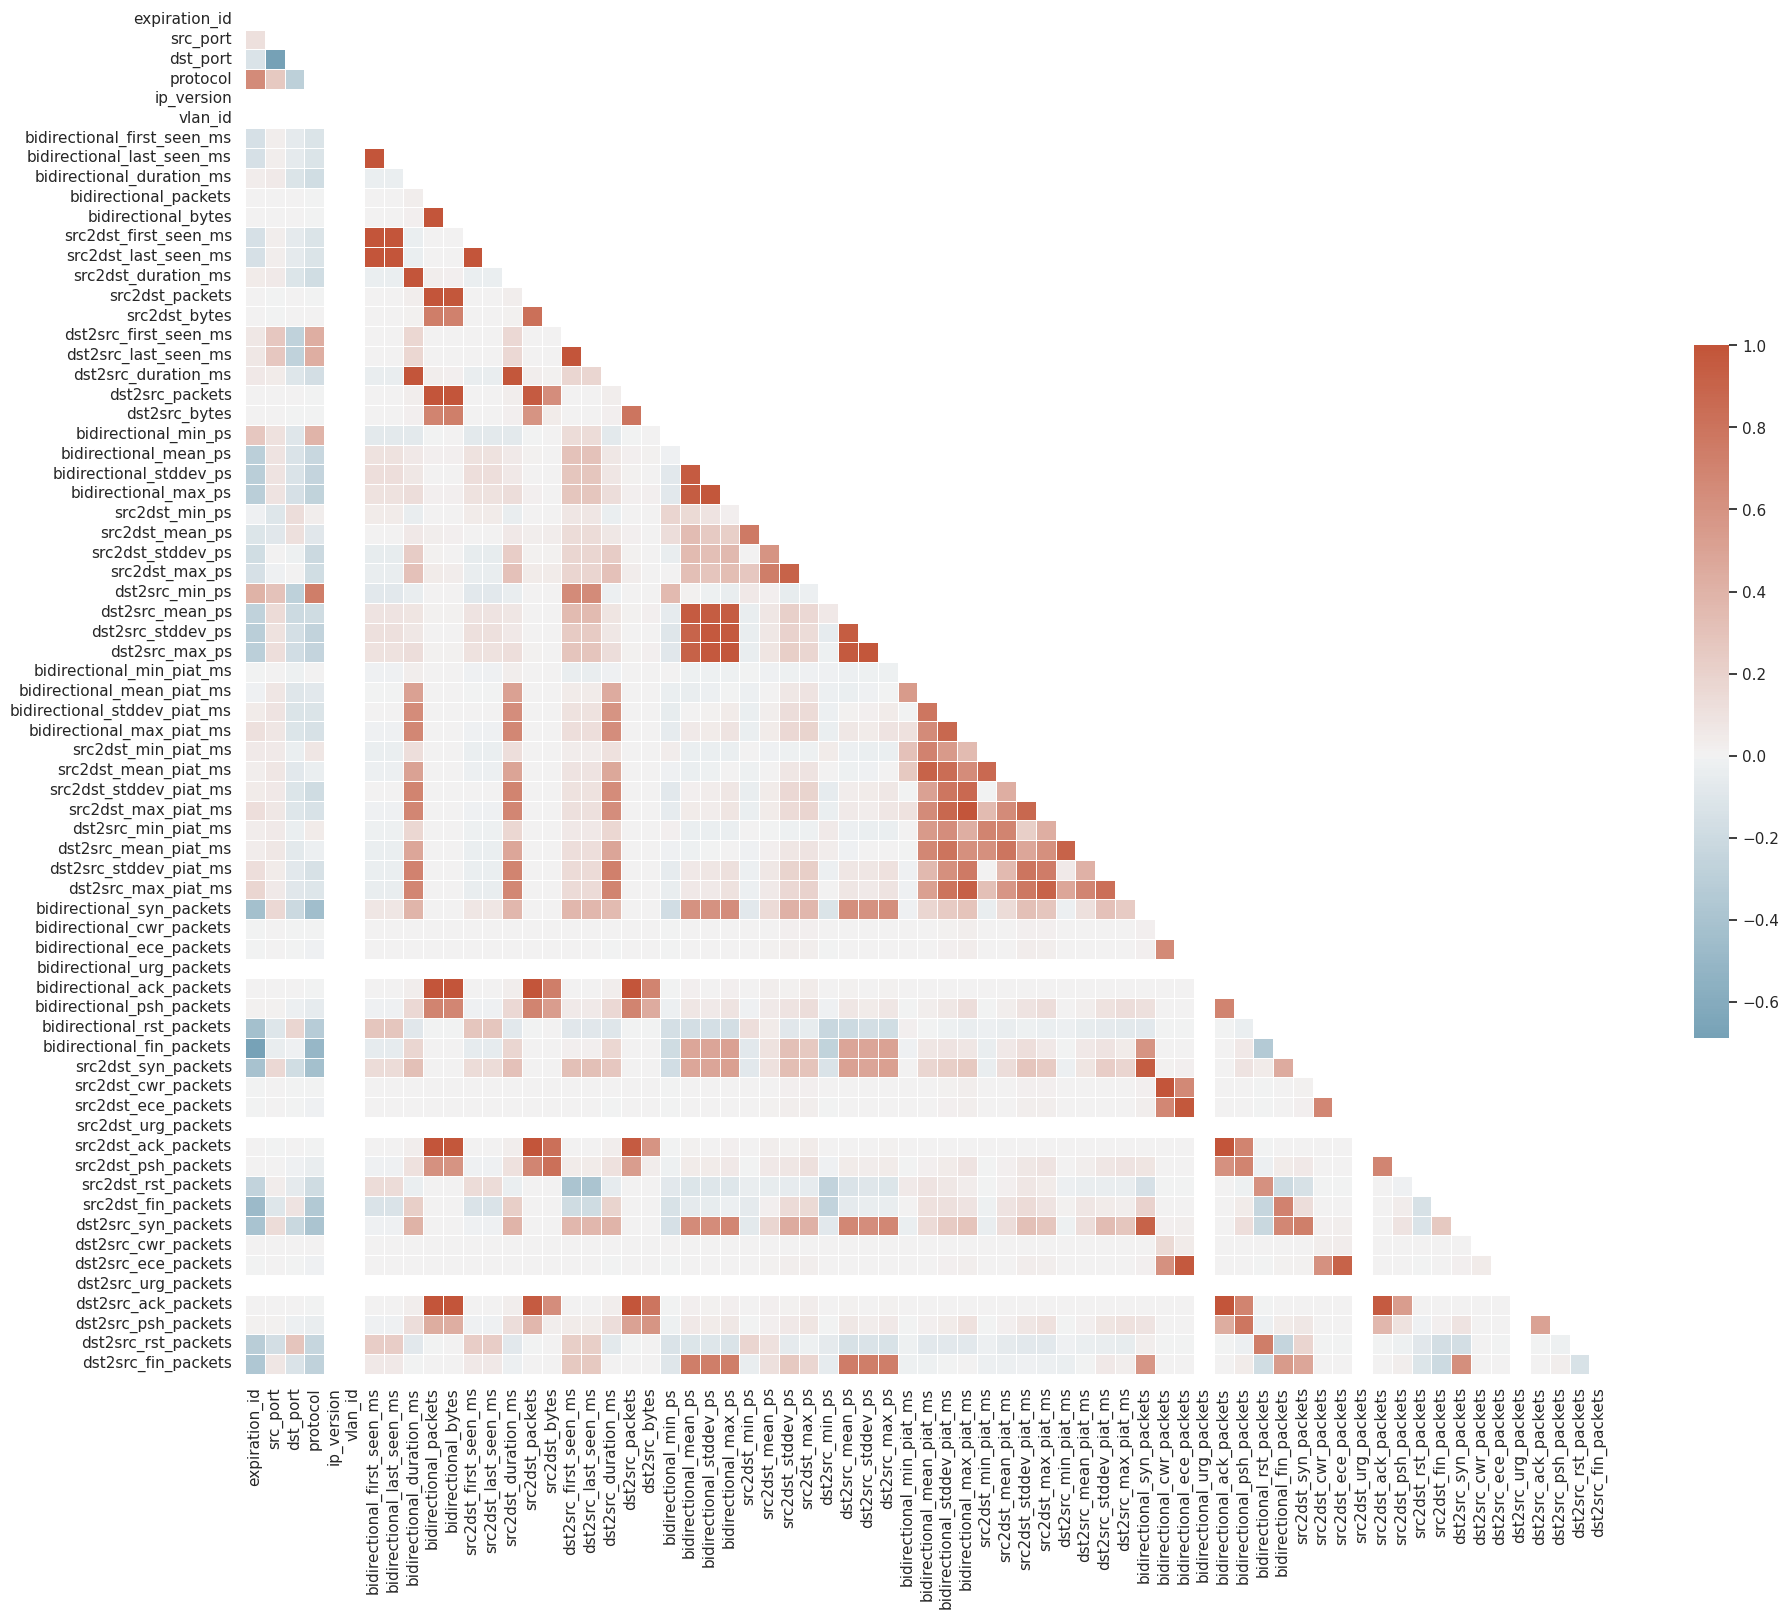

In [7]:
show_corr_matrix(ds)

In [15]:
(sum(ds.bidirectional_fin_packets > 2) / ds.shape[0]) * 100

1.925697647374796

In [17]:
(sum(ds.bidirectional_rst_packets > 2) / ds.shape[0]) * 100

2.864957219613563

In [595]:
correlation_matrix = ds.select_dtypes(include=['number','bool']).corr()

In [596]:
# Finding pairs with correlation greater than 0.9
correlation_threshold = 0.97
correlation_pairs = []

# Iterate through the upper triangle of the correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            pair = (
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            )
            correlation_pairs.append(pair)

print(f"Pairs with correlation over {correlation_threshold * 100}%:")
for pair in correlation_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]}")

Pairs with correlation over 97.0%:
fwd_pkts_tot - bwd_pkts_tot: 0.9977736565346315
fwd_pkts_tot - bwd_data_pkts_tot: 0.9981238640834618
fwd_pkts_tot - fwd_header_size_tot: 0.9983024676710928
fwd_pkts_tot - bwd_header_size_tot: 0.9969284507099473
fwd_pkts_tot - flow_ACK_flag_count: 0.9994240451360137
bwd_pkts_tot - bwd_data_pkts_tot: 0.9993969235398683
bwd_pkts_tot - fwd_header_size_tot: 0.9956196867430672
bwd_pkts_tot - bwd_header_size_tot: 0.999059175317736
bwd_pkts_tot - flow_ACK_flag_count: 0.9994481168048883
fwd_data_pkts_tot - fwd_PSH_flag_count: 0.996370720580026
bwd_data_pkts_tot - fwd_header_size_tot: 0.9963652785942658
bwd_data_pkts_tot - bwd_header_size_tot: 0.998580945909404
bwd_data_pkts_tot - flow_ACK_flag_count: 0.9993157051503467
fwd_pkts_per_sec - flow_pkts_per_sec: 0.9745616615733033
bwd_pkts_per_sec - flow_pkts_per_sec: 0.9747202135752829
fwd_header_size_tot - bwd_header_size_tot: 0.9956178586071448
fwd_header_size_tot - flow_ACK_flag_count: 0.9975134625150415
bwd_hea

In [597]:
correlated_features = []
correlation_with_target = []
feature_name = []

for i in correlation_pairs:
    if i[0] not in correlated_features:
        correlated_features.append(i[0])
    if i[1] not in correlated_features:
        correlated_features.append(i[1])

for i in correlated_features:
    correlation_with_target.append(correlation_matrix['Label'][i])
    feature_name.append(i)

correlation_with_target = pd.DataFrame({'Feature': feature_name, 'Correlation': correlation_with_target})
print(correlation_with_target.shape)

(26, 2)


In [598]:
correlation_with_target["Correlation"] = correlation_with_target["Correlation"].abs()
correlation_with_target.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
12,bwd_header_size_max,0.149017
11,bwd_header_size_min,0.135375
16,flow_pkts_payload.max,0.131481
15,bwd_pkts_payload.max,0.131387
7,fwd_PSH_flag_count,0.073178
6,fwd_data_pkts_tot,0.072526
14,flow_pkts_payload.min,0.053423
13,fwd_pkts_payload.min,0.053417
4,bwd_header_size_tot,0.015100
1,bwd_pkts_tot,0.014471


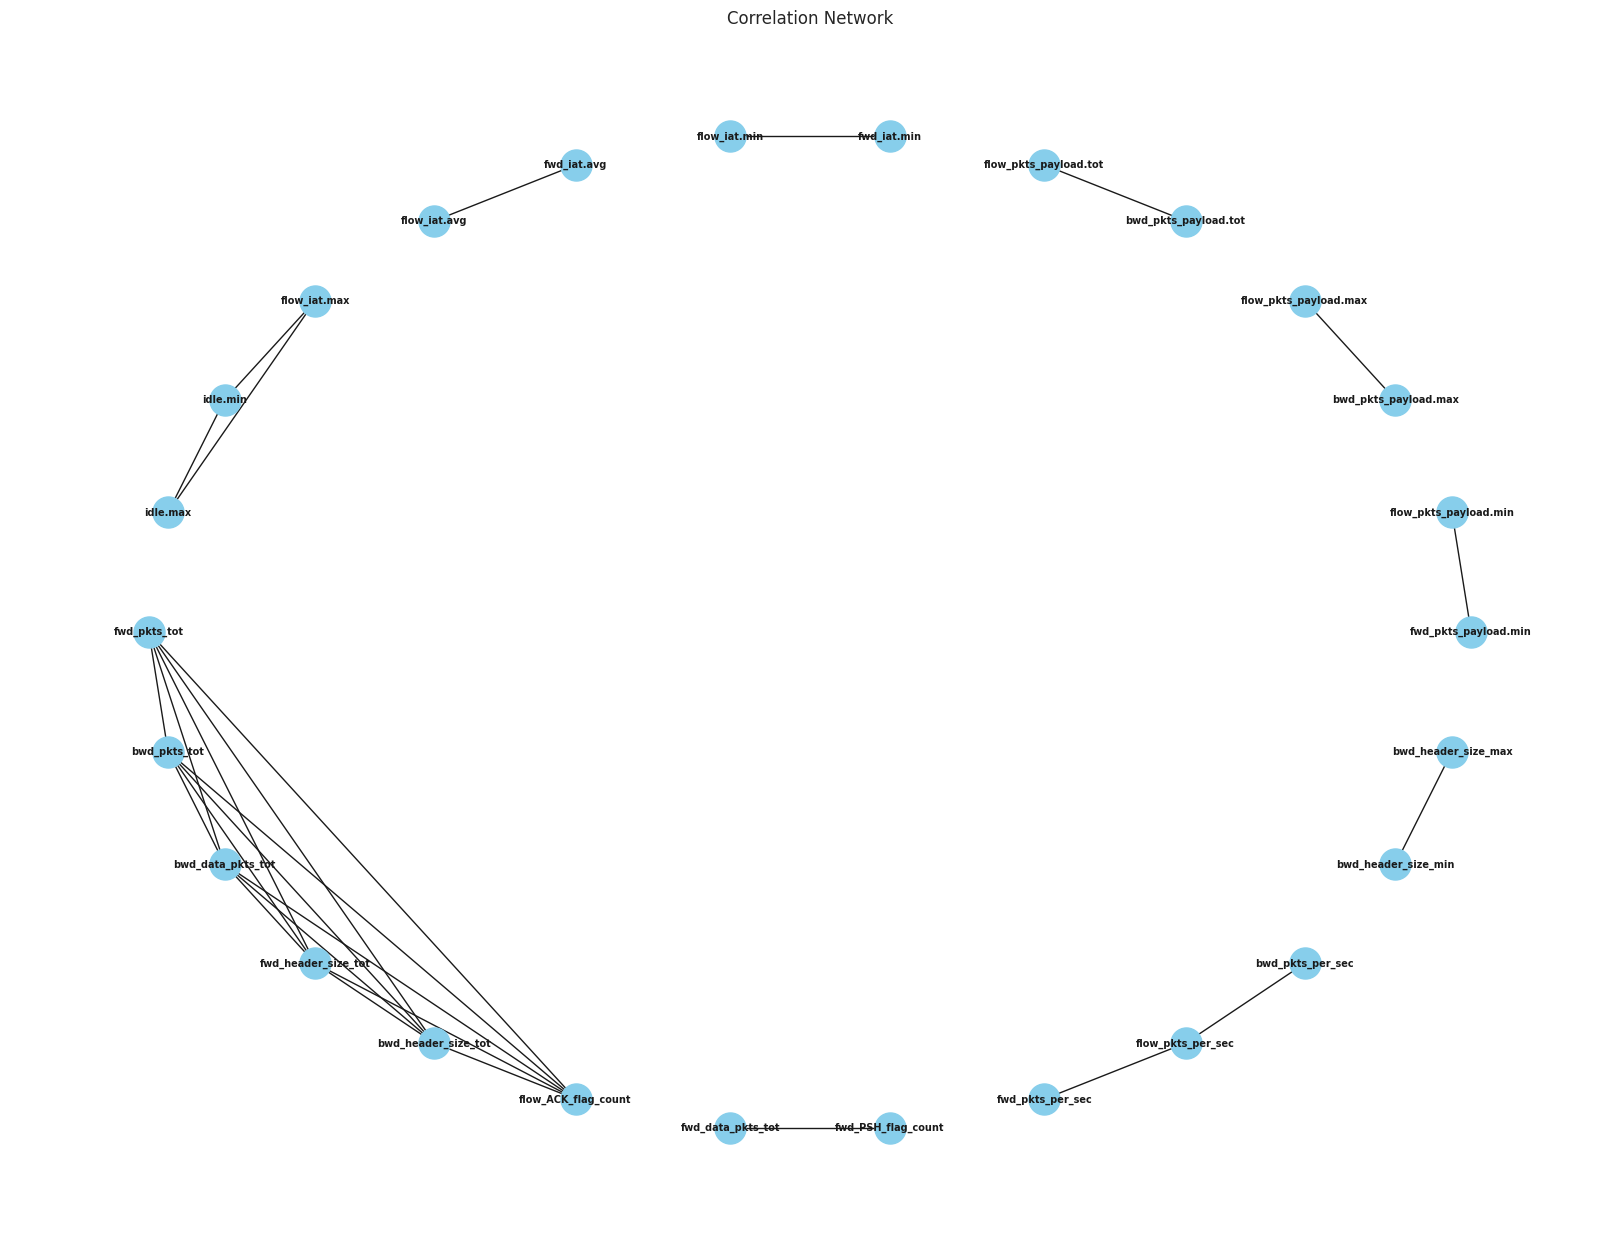

In [599]:
# Create a graph
G = nx.Graph()

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            G.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j])

# Visualizing the graph
plt.figure(figsize=(16, 12))
pos = nx.shell_layout(G)  # Positions for all nodes

nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_weight='bold', font_size=7)
plt.title('Correlation Network')
plt.show()

In [600]:
target_feature = 'Label'

feature_to_remove = []

# Finding connected components (clusters of correlated features)
connected_components = list(nx.connected_components(G))

# Analyzing each cluster
for cluster in connected_components:
    cluster = list(cluster)
    print(f"Cluster: {cluster}")
    max_corr = -1
    max_corr_feature = None
    
    for feature in cluster:
        if feature != target_feature:
            correlation_with_target = correlation_matrix.loc[feature, target_feature]
            if abs(correlation_with_target) > max_corr:
                max_corr = abs(correlation_with_target)
                max_corr_feature = feature
    
    print(f"Highest correlated feature with '{target_feature}': {max_corr_feature} (Correlation: {max_corr})")
    cluster.remove(max_corr_feature)
    feature_to_remove.extend(cluster)


Cluster: ['fwd_header_size_tot', 'bwd_header_size_tot', 'bwd_data_pkts_tot', 'flow_ACK_flag_count', 'bwd_pkts_tot', 'fwd_pkts_tot']
Highest correlated feature with 'Label': bwd_header_size_tot (Correlation: 0.015099913865850363)
Cluster: ['fwd_PSH_flag_count', 'fwd_data_pkts_tot']
Highest correlated feature with 'Label': fwd_PSH_flag_count (Correlation: 0.07317797680269945)
Cluster: ['bwd_pkts_per_sec', 'flow_pkts_per_sec', 'fwd_pkts_per_sec']
Highest correlated feature with 'Label': bwd_pkts_per_sec (Correlation: 0.004660033545999704)
Cluster: ['bwd_header_size_max', 'bwd_header_size_min']
Highest correlated feature with 'Label': bwd_header_size_max (Correlation: 0.14901723133291697)
Cluster: ['flow_pkts_payload.min', 'fwd_pkts_payload.min']
Highest correlated feature with 'Label': flow_pkts_payload.min (Correlation: 0.05342264750972606)
Cluster: ['bwd_pkts_payload.max', 'flow_pkts_payload.max']
Highest correlated feature with 'Label': flow_pkts_payload.max (Correlation: 0.13148095919

In [601]:
feature_to_remove

['fwd_header_size_tot',
 'bwd_data_pkts_tot',
 'flow_ACK_flag_count',
 'bwd_pkts_tot',
 'fwd_pkts_tot',
 'fwd_data_pkts_tot',
 'flow_pkts_per_sec',
 'fwd_pkts_per_sec',
 'bwd_header_size_min',
 'fwd_pkts_payload.min',
 'bwd_pkts_payload.max',
 'bwd_pkts_payload.tot',
 'flow_iat.min',
 'flow_iat.avg',
 'flow_iat.max',
 'idle.min']

In [602]:
len(feature_to_remove)

16